# Exploratory Data Analysis for the Delta Analytics Teaching Fellowship

**Author:** *Cynthia Thinwa*

## INTRODUCTION

### DATA HANDLING PRACTICES:

* Based on Twitter API best practice, the actual data will not be shared, only Twitter's tweet IDs for future reference
* The data will be cleaned to remove personally identifiable information like emails and phone numbers
* Content published on social media platforms belongs to the public domain with the various authors having given consent

Data collection was done from a Microsoft command line running

`twint -s %23kot --since "2020-06-01 03:00:00" --until "2021-06-01 03:00:00" -o kotdata.csv --csv`

## EXPLORATORY DATA ANALYSIS

### Introduction

The raw data was loaded as follows, with the following characteristics:


In [1]:
import numpy as np
import pandas as pd
import os
import json
import plotly.express as px # for data visualization
#!pip install gensim
#!pip install python-Levenshtein
from gensim.models.doc2vec import Doc2Vec, TaggedDocument #tokenize and tag each tweet
#!pip install sklearn
from sklearn.cluster import KMeans

In [2]:
%load_ext rpy2.ipython

c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R

library(dplyr)
library(wordcloud)
library(RColorBrewer)
library(rtweet)
library(tidytext)
library(ggplot2)
library(wordcloud2)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: RColorBrewer



1. The number of tweets:

In [4]:
%%R

url <- "C:/storage/Personal drive backup/Career/Post-Masters/Delta Analytics Teaching Fellowship/EDA/2.kotdata.csv"
DATFdata <- read.delim(url)
dim(DATFdata)[1]

[1] 36305



2. The number of unique conversations had:


In [5]:
%%R

DATFdata$conversation_id <- factor(DATFdata$conversation_id)
DATFdata$id <- factor(DATFdata$id)

dim(as.data.frame(table(DATFdata$conversation_id)))[1]

[1] 35388



3. The number of unique users speaking:


In [6]:
%%R

DATFdata$user_id <- factor(DATFdata$user_id)

dim(as.data.frame(table(DATFdata$user_id)))[1]

[1] 11049



4. The most frequent language of posting:


In [7]:
%%R

lang <- as.data.frame(table(DATFdata$language))
colnames(lang) <- c('Language','Frequency')
head(lang[order(lang$Freq, decreasing = TRUE),],n=1)

  Language Frequency
8       en     27504



5. The date on which most tweets were posted (tweets were from 1st June 2020 UTC+3 upto 1st June 2021 UTC+3): 


In [8]:
%%R

dates <- as.data.frame(table(DATFdata$date))
colnames(dates) <- c('Date','Frequency')
head(dates[order(dates$Freq, decreasing = TRUE),],n=1)

          Date Frequency
262 2021-02-17       406



### Text transformation

Text cleaning was as follows, using `eng_tweets$tweet[4]` as an example:


In [9]:
%%R

# Get organic tweets first; found that all tweets were organic!

# get only English ones:
eng_tweets <- DATFdata[DATFdata$language=='en',]

In [10]:
%%R

# Remove funny symbols
eng_tweets$tweet <- iconv(eng_tweets$tweet, from = 'UTF-8', to = 'ISO-8859-1', sub = '')
eng_tweets$tweet <- iconv(eng_tweets$tweet, from = 'ISO-8859-1', to = 'UTF-8', sub = '')

eng_tweets$tweet[1:15]

 [1] "@smackasoreass @TobiBWY @E_Teezey1286 Yes, how could you?? #KOT"                                                                                                                                                                                                                                                     
 [2] "Im sure this was a demo video. #kot #kenya #africa #ufisadi"                                                                                                                                                                                                                                                         
 [3] "The generation that buys phones that cost 3 times their parent's monthly salary are surprised that their parents think that they are working somewhere. The parents are just telling them to keep working  #kot"                                                                                                     
 [4] "@ManUnitedZone_ Made in the streets of mathare

From cffi callback <function _consolewrite_ex at 0x000001F32B5198B0>:
Traceback (most recent call last):
  File "c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 160: invalid start byte


In [11]:
%%R

# Get organic tweets first; found that all tweets were organic!

# get only English ones:
eng_tweets <- DATFdata[DATFdata$language=='en',]; print(eng_tweets$tweet[4])

# Remove funny symbols
eng_tweets$tweet <- iconv(eng_tweets$tweet, from = 'UTF-8', to = 'ISO-8859-1', sub = ''); print(eng_tweets$tweet[4]); cat('\n')

eng_tweets$tweet <- iconv(eng_tweets$tweet, from = 'ISO-8859-1', to = 'UTF-8', sub = ''); print(eng_tweets$tweet[4]); cat('\n')

eng_tweets$tweet <- gsub("https\\S*", "", eng_tweets$tweet); print(eng_tweets$tweet[4]); cat('\n') #remove urls

eng_tweets$tweet <- gsub("@", "", eng_tweets$tweet); print(eng_tweets$tweet[4]); cat('\n') #remove mentions symbol

eng_tweets$tweet <- gsub("#*", "", eng_tweets$tweet); print(eng_tweets$tweet[4]); cat('\n') #remove hashtags symbol

eng_tweets$tweet <- gsub("[\r\n]", " ", eng_tweets$tweet); print(eng_tweets$tweet[4]); cat('\n') #remove newline characters

#(we have separate columns with the details)
# Punctuation was managed as follows:
eng_tweets$tweet <- gsub("'", "", eng_tweets$tweet); print(eng_tweets$tweet[4]); cat('\n')

eng_tweets$tweet <- gsub("[[:punct:]]", " ", eng_tweets$tweet); print(eng_tweets$tweet[4]); cat('\n')

eng_tweets$tweet <- gsub("amp", "", eng_tweets$tweet); print(eng_tweets$tweet[4]); cat('\n') # remove ampersands

# Finally, everything was made lowercase
eng_tweets$tweet <- tolower(eng_tweets$tweet); print(eng_tweets$tweet[4])

[1]

From cffi callback <function _consolewrite_ex at 0x000001F32B5198B0>:
Traceback (most recent call last):
  File "c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 292: invalid continuation byte



[1] "@ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to @LasetoAbdaz @babazubeyyr @VictorWanyama #KOT.I insist,The First Kenyan to play for Manchester United .you'll land in trouble for misinforming the masses "

[1] "@ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to @LasetoAbdaz @babazubeyyr @VictorWanyama #KOT.I insist,The First Kenyan to play for Manchester United .you'll land in trouble for misinforming the masses "

[1] "@ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to @LasetoAbdaz @babazubeyyr @VictorWanyama #KOT.I insist,The First Kenyan to play for Manchester United .you'll land in trouble for misinforming the masses "

[1] "ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to LasetoAbdaz babazubeyyr Victo

In [12]:
%%R

# Tokenize words
Words <- eng_tweets %>%
  select(tweet) %>%
  unnest_tokens(word, tweet)


### Word Frequency


Selecting by n


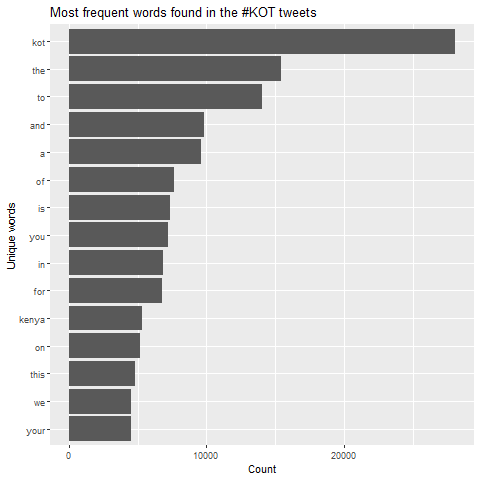

In [13]:
%%R

Words %>% # gives you a bar chart of the most frequent words found in the tweets
  count(word, sort = TRUE) %>%
  top_n(15) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(x = word, y = n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() +
  labs(y = "Count",
       x = "Unique words",
       title = "Most frequent words found in the #KOT tweets")

Joining, by = "word"
Selecting by n


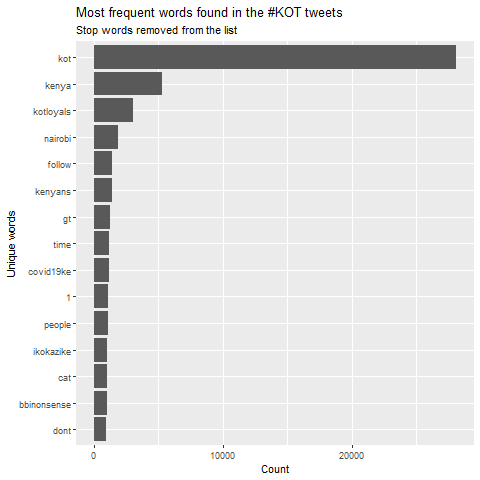

In [14]:
%%R

# remove stop words
Words <- Words %>%
  anti_join(stop_words)

Words %>% # gives you a bar chart of the most frequent words found in the tweets
  count(word, sort = TRUE) %>%
  top_n(15) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(x = word, y = n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() +
  labs(y = "Count",
       x = "Unique words",
       title = "Most frequent words found in the #KOT tweets",
       subtitle = "Stop words removed from the list")


### Hashtag Frequency

All tweets have the hashtag `#KOT`, but we are interested in what else this community talks about, so this hashtag will have to be removed from our visualization.


In [15]:
%%R

eng_tweets$hashtags <- as.character(eng_tweets$hashtags)

eng_tweets$hashtags <- gsub("[[:punct:]]", "", eng_tweets$hashtags)

# every hashtag was made lowercase
eng_tweets$hashtags <- tolower(eng_tweets$hashtags)

# and #KOT was removed before tokenization
eng_tweets$hashtags <- gsub("kot", "", eng_tweets$hashtags)

Hashtags <- eng_tweets %>%
  select(hashtags) %>%
  unnest_tokens(word, hashtags)

Hashtags_count <- as.data.frame(table(Hashtags$word))

viz1 <- wordcloud2(Hashtags_count, size=0.7)

![](viz1.PNG)

In [16]:
%%R
df <- head(Hashtags_count[order(Hashtags_count$Freq, decreasing = TRUE),], n=15)
df

                   Var1 Freq
6970              kenya 3074
8039             loyals 3050
9173            nairobi 1196
2883          covid19ke 1187
6033          ikokazike 1016
1178        bbinonsense  989
2133                cat  871
4957               gato  815
8181   mainaandkingangi  756
12803       teamclassic  607
4897  gainwithxtiandela  564
4627              forex  556
2874            covid19  522
10673     punguzamizigo  501
2136          catattire  483


Based on the results above

* platform (`#loyals`),
* patriotism (`#kenya` and `#nairobi`),
* radio (`#mainaandkingangi` and `#teamclassic`),
* political trends (`#bbinonsense` and `#punguzamizigo`)
* job ads(`#ikokazike` and `#ikokazi`) and
* cats (`#cat` and `#gato`)

took centre stage. 


### People of Influence

In this area, we are interested in identifying people mentioned most frequently.

The text, using `eng_tweets$mentions[4]` as an example was first converted as follows:


In [17]:
%%R

eng_tweets$mentions[4]
# Remove funny symbols
eng_tweets$mentions <- iconv(eng_tweets$mentions, from = 'UTF-8', to = 'UTF-8');eng_tweets$mentions[4]

eng_tweets$mentions <- stringr::str_replace_all(
  eng_tweets$mentions, "\'", "\"")
eng_tweets$mentions <- gsub("[", "", eng_tweets$mentions, fixed = TRUE)
eng_tweets$mentions <- gsub("]", "", eng_tweets$mentions, fixed = TRUE)

df <- as.data.frame(eng_tweets$mentions); dim(df)
df[df == ""] <- NA  
df <- na.omit(df); dim(df)


[1] 6887    1


In [18]:
#get file location
os.getcwd()

'C:\\Users\\CT\\Documents\\GitHub\\Delta-Analytics-2021-CT-Project'

In [19]:
%%R

write.csv(df$`eng_tweets$mentions`,'C:/Users/CT/Documents/GitHub/Delta-Analytics-2021-CT-Project/dicts.csv')

In [20]:
dicts = pd.read_csv('dicts.csv')
dicts.head(5)

,Unnamed: 0,x
0,1,"{""screen_name"": ""lasetoabdaz"", ""name"": ""abdaz""..."
1,2,"{""screen_name"": ""gracekuriake"", ""name"": ""grace..."
2,3,"{""screen_name"": ""bravinyuri"", ""name"": ""bravin ..."
3,4,"{""screen_name"": ""ukinkenya"", ""name"": ""uk in ke..."
4,5,"{""screen_name"": ""shopmduka"", ""name"": ""mduka"", ..."


In [21]:
# Delete the column
dicts = dicts.drop(labels='Unnamed: 0', axis=1)
dicts.shape

(6887, 1)

In [22]:
dicts.head(5)

,x
0,"{""screen_name"": ""lasetoabdaz"", ""name"": ""abdaz""..."
1,"{""screen_name"": ""gracekuriake"", ""name"": ""grace..."
2,"{""screen_name"": ""bravinyuri"", ""name"": ""bravin ..."
3,"{""screen_name"": ""ukinkenya"", ""name"": ""uk in ke..."
4,"{""screen_name"": ""shopmduka"", ""name"": ""mduka"", ..."


In [23]:
single_dicts_copy = dicts.copy()
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace('{','',regex=False)
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace('}','',regex=False)
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace(' ','',regex=False)
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace("\"",'',regex=False)
single_dicts_copy.columns = ['dictionary']
print(single_dicts_copy.iloc[0,0],'\n')
print(single_dicts_copy.iloc[1,0])

screen_name:lasetoabdaz,name:abdaz,id:502972112,screen_name:babazubeyyr,name:<U+0001F40E>,id:1379069357683322886,screen_name:victorwanyama,name:victorwanyama,id:327549892 

screen_name:gracekuriake,name:gracekuria,id:2172617474


In [24]:
long_lst = list(single_dicts_copy.iloc[:,0].values)
info = []
i=0

for i in range(len(single_dicts_copy.iloc[:,0])):
    item = long_lst[i].split(",")
    info.append(item)

print(len(info),'\n')
info[0]

6887 



['screen_name:lasetoabdaz',
 'name:abdaz',
 'id:502972112',
 'screen_name:babazubeyyr',
 'name:<U+0001F40E>',
 'id:1379069357683322886',
 'screen_name:victorwanyama',
 'name:victorwanyama',
 'id:327549892']

In [25]:
screen_names = []
i=0
# initializing substring
subs = 'screen_name'

for i in range(len(info)):
    item = list(filter(lambda x: subs in x, info[i]))
    screen_names.append(item)

print(len(screen_names),'\n')
screen_names[0:5]

6887 



[['screen_name:lasetoabdaz',
  'screen_name:babazubeyyr',
  'screen_name:victorwanyama'],
 ['screen_name:gracekuriake'],
 ['screen_name:bravinyuri', 'screen_name:moh_kenya'],
 ['screen_name:ukinkenya',
  'screen_name:usaideducation',
  'screen_name:gpforeducation',
  'screen_name:carolinemutoko'],
 ['screen_name:shopmduka']]

In [26]:
ids = []
i=0
# initializing substring
subs = 'id:'

for i in range(len(info)):
    item = list(filter(lambda x: subs in x, info[i]))
    ids.append(item)

print(len(ids),'\n')
ids[0:5]

6887 



[['id:502972112', 'id:1379069357683322886', 'id:327549892'],
 ['id:2172617474'],
 ['id:178677263', 'id:4871317955'],
 ['id:205171299', 'id:460364759', 'id:171314974', 'id:2301252554'],
 ['id:739841206700675072']]

In [27]:
flat_list = [item for sublist in screen_names for item in sublist]
screen_names_s = pd.Series(flat_list)
screen_names_s.shape

(16235,)

In [28]:
flat_list = [item for sublist in ids for item in sublist]
ids_s = pd.Series(flat_list)
ids_s.shape

(16235,)

In [29]:
data = {"id": ids_s,
        "screen_name": screen_names_s}

persons_df = pd.concat(data,axis=1)
persons_df.head(5)

,id,screen_name
0,id:502972112,screen_name:lasetoabdaz
1,id:1379069357683322886,screen_name:babazubeyyr
2,id:327549892,screen_name:victorwanyama
3,id:2172617474,screen_name:gracekuriake
4,id:178677263,screen_name:bravinyuri


In [30]:
# Remove identifiers
persons_df['id'] = persons_df['id'].str.replace('id:','',regex=False)
persons_df['screen_name'] = persons_df['screen_name'].str.replace('screen_name:','',regex=False)
persons_df.head(5)

,id,screen_name
0,502972112,lasetoabdaz
1,1379069357683322886,babazubeyyr
2,327549892,victorwanyama
3,2172617474,gracekuriake
4,178677263,bravinyuri


In [31]:
# Export to R for wordcloud
persons_df.to_csv('C:/Users/CT/Documents/GitHub/Delta-Analytics-2021-CT-Project/Tweeps.csv')

In [32]:
%%R

persons <- read.csv('C:/Users/CT/Documents/GitHub/Delta-Analytics-2021-CT-Project/Tweeps.csv')

Tweep_count <- as.data.frame(table(persons$screen_name))

viz2 <- wordcloud2(Tweep_count, size=0.7)

![](viz2.PNG)

                Var1 Freq
3668 statehousekenya  278
3450      safebetske  233
3297     railaodinga  205
721   citizentvkenya  203
1001        dodzweit  197
2967        ntvkenya  162
733  classic105kenya  154
896        dci_kenya  150
4213    williamsruto  144
2832     nassemblyke  139


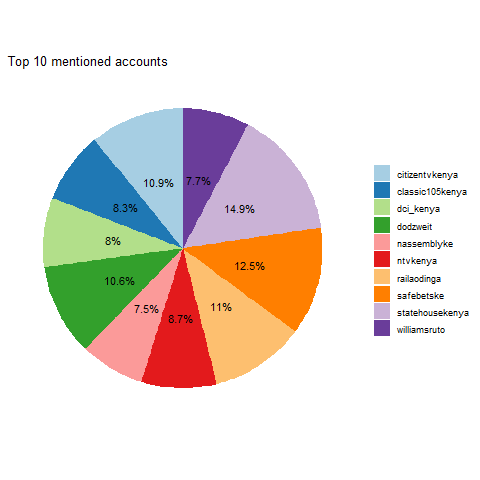

In [33]:
%%R

df <- head(Tweep_count[order(Tweep_count$Freq, decreasing = TRUE),],n=10); print(df)

ggplot(data=df, aes(x="", y=Freq, fill=Var1)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) +
  labs(x = NULL, y = NULL, fill = NULL) +
  theme_classic() +
  theme(axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  scale_fill_brewer(palette="Paired") +
  geom_text(aes(label = paste0(round(Freq/sum(Freq)*100, 1), "%")), position = position_stack(vjust=0.5)) +
  labs(title = "Top 10 mentioned accounts")

Based on the result above, the most mentioned 'persons' over the past year on Twitter were 

* political institutions such as `@statehousekenya`, `@dcikenya` and `@nassemblyke`,
* a betting firm, `@safebetske`,
* politicians such as `@railaodinga` (the leader of Kenyan opposition parties) and `@williamsruto` (the current deputy vice president) as well as
* media houses such as `@citizentvkenya`, `@ntvkenya` and `@classic105kenya` and
* an inspiration account, `@dodzweit` (A reverend who posts inspirational and at times Christian content)

A possible explanation for this phenomenon is that 2022 will be an election year, and the two political leaders are running against each other and campaigning online.

However,

* `@dodzweit` was mentioned only by the church s/he pastors, `@cotchurchhq`, primarily in short summaries of his/her talks.
* `@safebetske` was mentioned only by a forex trader, `@theforexguyke`, primarily in retweets.



## FEATURE ENGINEERING \& MODELLING

In [34]:
%%R

model_data <- cbind.data.frame(eng_tweets$id, eng_tweets$conversation_id,
                               eng_tweets$date, eng_tweets$time,
                               eng_tweets$user_id, eng_tweets$tweet,
                               eng_tweets$mentions, eng_tweets$hashtags)
write.csv(model_data, 'eng_model_data.csv')
model_data[1:5,]

        eng_tweets$id eng_tweets$conversation_id eng_tweets$date
1  1.399492256718e+18        1399231989673234432      2021-06-01
2 1399486902898761728        1399486902898761728      2021-06-01
3 1399486184829734912        1399486184829734912      2021-06-01
4 1399485584285044736        1399441176831442944      2021-06-01
5 1399476235680559104        1399476235680559104      2021-06-01
  eng_tweets$time  eng_tweets$user_id
1        01:25:29 1184134876443881472
2        01:04:13          1827231318
3        01:01:22           257602883
4        00:58:59  949012273615515648
5        00:21:50            98336047
                                                                                                                                                                                                                                                              eng_tweets$tweet
1                                                                                                              

In [35]:
data = pd.read_csv('eng_model_data.csv')
data

,Unnamed: 0,eng_tweets$id,eng_tweets$conversation_id,eng_tweets$date,eng_tweets$time,eng_tweets$user_id,eng_tweets$tweet,eng_tweets$mentions,eng_tweets$hashtags
0,1,1.399492e+18,1.399232e+18,2021-06-01,01:25:29,1.184135e+18,smackasoreass tobibwy e teezey1286 yes how co...,NaN,NaN
1,2,1.399487e+18,1.399487e+18,2021-06-01,01:04:13,1.827231e+09,im sure this was a demo video kot kenya afric...,NaN,kenya africa ufisadi
2,3,1.399486e+18,1.399486e+18,2021-06-01,01:01:22,2.576029e+08,the generation that buys phones that cost 3 ti...,NaN,NaN
3,4,1.399486e+18,1.399441e+18,2021-06-01,00:58:59,9.490123e+17,manunitedzone made in the streets of mathare ...,"{""screen_name"": ""lasetoabdaz"", ""name"": ""abdaz""...",NaN
4,5,1.399476e+18,1.399476e+18,2021-06-01,00:21:50,9.833605e+07,madam gracekuriake we thank you for all the jo...,"{""screen_name"": ""gracekuriake"", ""name"": ""grace...",NaN
...,...,...,...,...,...,...,...,...,...
27499,27500,1.267312e+18,1.267312e+18,2020-06-01,07:26:36,7.188911e+17,at 57 years old kenya is a typical african m...,NaN,madarakaday
27500,27501,1.267303e+18,1.267303e+18,2020-06-01,06:53:04,2.224274e+08,our beautiful kenyanationalanthem sung by more...,"{""screen_name"": ""statehousekenya"", ""name"": ""st...",kenyanationalanthem choralmusic
27501,27502,1.267295e+18,1.267295e+18,2020-06-01,06:20:39,5.971840e+08,times are tough though but some are really tr...,NaN,ikokazike
27502,27503,1.267293e+18,1.267291e+18,2020-06-01,06:14:31,3.508761e+08,emejemoses davidkimmzz brigademacharia classic...,NaN,mainaandkingangi teamclassic fridaysexiestniec...


In [36]:
model_data = data.copy()

print(model_data.dtypes)

model_data['eng_tweets$id'] = model_data['eng_tweets$id'].astype('category')
model_data['eng_tweets$conversation_id'] = model_data['eng_tweets$conversation_id'].astype('category')
model_data['eng_tweets$user_id'] = model_data['eng_tweets$user_id'].astype('category')
model_data['timestamp'] = model_data['eng_tweets$date'] + ' ' + model_data['eng_tweets$time']
model_data['timestamp'] = pd.to_datetime(model_data['timestamp'])
model_data = model_data.drop(['Unnamed: 0', 'eng_tweets$date', 'eng_tweets$time',
                              'eng_tweets$mentions', 'eng_tweets$hashtags'],1)

print('\n', model_data.dtypes)

Unnamed: 0                      int64
eng_tweets$id                 float64
eng_tweets$conversation_id    float64
eng_tweets$date                object
eng_tweets$time                object
eng_tweets$user_id            float64
eng_tweets$tweet               object
eng_tweets$mentions            object
eng_tweets$hashtags            object
dtype: object

 eng_tweets$id                       category
eng_tweets$conversation_id          category
eng_tweets$user_id                  category
eng_tweets$tweet                      object
timestamp                     datetime64[ns]
dtype: object


In [37]:
model_data.columns = ['tweet_id', 'conversation_id', 'user_id', 'tweet', 'timestamp']
model_data

,tweet_id,conversation_id,user_id,tweet,timestamp
0,1.399492e+18,1.399232e+18,1.184135e+18,smackasoreass tobibwy e teezey1286 yes how co...,2021-06-01 01:25:29
1,1.399487e+18,1.399487e+18,1.827231e+09,im sure this was a demo video kot kenya afric...,2021-06-01 01:04:13
2,1.399486e+18,1.399486e+18,2.576029e+08,the generation that buys phones that cost 3 ti...,2021-06-01 01:01:22
3,1.399486e+18,1.399441e+18,9.490123e+17,manunitedzone made in the streets of mathare ...,2021-06-01 00:58:59
4,1.399476e+18,1.399476e+18,9.833605e+07,madam gracekuriake we thank you for all the jo...,2021-06-01 00:21:50
...,...,...,...,...,...
27499,1.267312e+18,1.267312e+18,7.188911e+17,at 57 years old kenya is a typical african m...,2020-06-01 07:26:36
27500,1.267303e+18,1.267303e+18,2.224274e+08,our beautiful kenyanationalanthem sung by more...,2020-06-01 06:53:04
27501,1.267295e+18,1.267295e+18,5.971840e+08,times are tough though but some are really tr...,2020-06-01 06:20:39
27502,1.267293e+18,1.267291e+18,3.508761e+08,emejemoses davidkimmzz brigademacharia classic...,2020-06-01 06:14:31


In [38]:
model_data['tagged_tweets'] = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(model_data.tweet)]#display the tagged docs

model_data

,tweet_id,conversation_id,user_id,tweet,timestamp,tagged_tweets
0,1.399492e+18,1.399232e+18,1.184135e+18,smackasoreass tobibwy e teezey1286 yes how co...,2021-06-01 01:25:29,"([smackasoreass, tobibwy, e, teezey1286, yes, ..."
1,1.399487e+18,1.399487e+18,1.827231e+09,im sure this was a demo video kot kenya afric...,2021-06-01 01:04:13,"([im, sure, this, was, a, demo, video, , kot, ..."
2,1.399486e+18,1.399486e+18,2.576029e+08,the generation that buys phones that cost 3 ti...,2021-06-01 01:01:22,"([the, generation, that, buys, phones, that, c..."
3,1.399486e+18,1.399441e+18,9.490123e+17,manunitedzone made in the streets of mathare ...,2021-06-01 00:58:59,"([manunitedzone, , made, in, the, streets, of,..."
4,1.399476e+18,1.399476e+18,9.833605e+07,madam gracekuriake we thank you for all the jo...,2021-06-01 00:21:50,"([madam, gracekuriake, we, thank, you, for, al..."
...,...,...,...,...,...,...
27499,1.267312e+18,1.267312e+18,7.188911e+17,at 57 years old kenya is a typical african m...,2020-06-01 07:26:36,"([at, 57, years, old, , , kenya, is, a, typica..."
27500,1.267303e+18,1.267303e+18,2.224274e+08,our beautiful kenyanationalanthem sung by more...,2020-06-01 06:53:04,"([our, beautiful, kenyanationalanthem, sung, b..."
27501,1.267295e+18,1.267295e+18,5.971840e+08,times are tough though but some are really tr...,2020-06-01 06:20:39,"([times, are, tough, though, , but, some, are,..."
27502,1.267293e+18,1.267291e+18,3.508761e+08,emejemoses davidkimmzz brigademacharia classic...,2020-06-01 06:14:31,"([emejemoses, davidkimmzz, brigademacharia, cl..."


Based on the data above, unsupervised machine learning will be applied to:
* tranform tweets into numerical vectors (learn more [here](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)) using [Doc2Vec](https://towardsdatascience.com/how-to-vectorize-text-in-dataframes-for-nlp-tasks-3-simple-techniques-82925a5600db)
* use k-means to [classify the tweets](https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483), constructing a label in the process.
* use Catboost to [predict the constructed label](https://towardsdatascience.com/unconventional-sentiment-analysis-bert-vs-catboost-90645f2437a9)

In [39]:
# transform the vectors into numerical vectors
model = Doc2Vec(dm=1, vector_size=32, min_count=1, workers=8, epochs = 20) #instantiate model
model.build_vocab(model_data['tagged_tweets']) #build vocab
model.train(model_data['tagged_tweets'], total_examples=model.corpus_count,
            epochs=model.epochs) # train the vectorization model

#generate vectors
tweet_vec = [model.infer_vector((model_data['tweet'][i].split(' '))) 
            for i in range(0,len(model_data['tweet']))]
tweet_vec[0]

array([-0.17653614, -0.25310925,  0.24785142, -0.0856939 , -0.38185838,
       -0.28306717,  0.5688941 ,  0.37003067, -0.09463557,  0.03243343,
        0.27418363,  0.20167445, -0.04068308,  0.01876783, -0.30707133,
        0.02747647, -0.36250433,  0.18087377, -0.11697781, -0.00573378,
        0.3114165 ,  0.39301977,  0.37986636,  0.07802428,  0.3048214 ,
       -0.15517153, -0.2560343 ,  0.36010465, -0.29595116, -0.33837503,
       -0.06836036, -0.17991614], dtype=float32)

In [40]:
tweet_vec[3]

array([ 0.12336502, -0.23700796,  0.12452584,  0.06243835,  0.2460464 ,
       -0.32607242, -0.14635251,  0.23706554, -0.07261702, -0.28097168,
        0.46395218, -0.23384145,  0.2530208 ,  0.08617968, -0.7100795 ,
        0.00327573, -0.31987244,  0.424327  ,  0.02318177,  0.1416834 ,
        0.04660807, -0.28571457,  0.04354312, -0.29262346,  0.28583005,
        0.17806229, -0.04542474,  0.840281  , -0.09505097,  0.10161769,
       -0.32478598,  0.45473066], dtype=float32)

### Using `tweet_vector` as the only feature

In [41]:
kmeans_data0 = pd.DataFrame()
kmeans1 = KMeans(n_clusters=2, random_state=0).fit(tweet_vec) # classify data into 2 pools based on document vectors
kmeans_data0['label'] = pd.Series(kmeans1.labels_)
kmeans_data0['tweet_vector'] = tweet_vec #set list to dataframe column
kmeans_data0

,label,tweet_vector
0,1,"[-0.17653614, -0.25310925, 0.24785142, -0.0856..."
1,0,"[0.25355285, 0.07727459, 0.071957774, 0.063013..."
2,1,"[0.10068261, 0.0010179348, -0.14842565, 0.4391..."
3,1,"[0.12336502, -0.23700796, 0.12452584, 0.062438..."
4,0,"[-0.43685687, -0.0767686, -0.21036829, -0.0182..."
...,...,...
27499,1,"[-0.33381104, -0.3238593, 0.12905833, 0.381198..."
27500,1,"[0.36172888, -0.23162396, 0.31951, -0.00247151..."
27501,1,"[-0.1828131, -0.02926904, 0.18353638, 0.085904..."
27502,0,"[-0.28455076, -0.025942406, -0.1446797, 0.0914..."


In [42]:
# Tweets labeled 0:
i=0
for i in range(26):
    if kmeans_data0['label'][i] == 0:
        print(model_data.tweet[i], '\n', '\n')
    i+=1

im sure this was a demo video  kot kenya africa ufisadi 
 

madam gracekuriake we thank you for all the job updates that you give kot you are impacting lives    one job at a time  
 

7 more followers to go kot 
 

thank you bravinyuri for always engaging kot on matters mentalhealthke   i hope one day moh kenya will see the need to facilitate  finance  these conversations to reach the maaaaaaaany kenyans who are not online to benefit from the useful information shared here  
 

when you spend thousands of kshs to see queen of the jungle    then you spend thousands of kshs to see your queen on royale spring mattress  kot ikokazike keadrive kenyans parklands kotsokoni kot nairobi madarakaday2021 airbnb kenyan mattress madeinkenya madeinkenya   
 

it is always very stressful facing financial problems as a business  but there is help and advice available to help you tackle them before it gets too much to handle  so seek professional advice as soon as possible  kot kenlantips finance money

In [43]:
# Tweets labeled 1:
i=0
for i in range(26):
    if kmeans_data0['label'][i] == 1:
        print(model_data.tweet[i], '\n', '\n')
    i+=1

smackasoreass tobibwy e teezey1286 yes  how could you   kot 
 

the generation that buys phones that cost 3 times their parents monthly salary are surprised that their parents think that they are working somewhere  the parents are just telling them to keep working  kot 
 

manunitedzone  made in the streets of mathare nairobi kenya   he was nicknamed kenyan messi pride of kenya  friends to lasetoabdaz babazubeyyr victorwanyama kot i insist the first kenyan to play for manchester united  youll land in trouble for misinforming the masses  
 

i dont if you have that friend mwenye huwa mnachat na yeye ig  fb na watsapp at the same time na kwa hzo base zote mnaongea story different  kot 
 

  check out   taking online learning to a whole new level  kot ukinkenya usaideducation gpforeducation raiseyourhand diani carolinemutoko 
 

on spotlight to buy them sometime  first it was rusesabagina and now thebal is finished and so and so on         rwot kot uot  ssot    they will keep the media wi

### Using vectorized tweet elements, `user_id` and `conversation_id` as the features

In [45]:
tweet_vector = np.array(tweet_vec).tolist() #Create a list of lists

user_idLIST = []
for id in model_data.user_id:
    i=0
    for i in range(32):
        user_idLIST.append(id)
        i+=1
print('\n',len(user_idLIST),'\n')
print(user_idLIST[0:32],'\n','\n')

conversation_idLIST = []
for id in model_data.conversation_id:
    i=0
    for i in range(32):
        conversation_idLIST.append(id)
        i+=1
print(len(conversation_idLIST),'\n')
print(conversation_idLIST[0:32],'\n','\n')

#tweet_vectorLIST = kmeans_data.tweet_vector.flatten()
#print(kmeans_data.tweet_vector[0])
#tweet_vectorLIST[1:32]
print(len(np.array(tweet_vec).flatten()),'\n')
print(list(np.array(tweet_vec).flatten())[0:32],'\n')
print(list(np.array(tweet_vec).flatten())[32:64],'\n')


 880128 

[1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18, 1.1841348764438815e+18] 
 

880128 

[1.3992319896732344e+18, 1.3992319896732344e+18, 1.3992319896732344e+18, 1.3992319896732344e+18, 1.3992319896732344e+18, 1.3992319896732344e+18, 1.3992319896732344e+18, 1.3992319896732344e+18, 1.399231989673

In [47]:
kmeans_data1 = pd.DataFrame()
kmeans_data1['user_idLIST'] = pd.Series(user_idLIST)
kmeans_data1['conversation_idLIST'] = pd.Series(conversation_idLIST)
kmeans_data1['tweet_vectorLIST'] = pd.Series(np.array(tweet_vec).flatten())

kmeans2 = KMeans(n_clusters=2, random_state=0).fit(kmeans_data1) # classify data into 2 pools based on document vectors
kmeans_data1['label'] = pd.Series(kmeans2.labels_)

In [48]:
kmeans_data1.head(32)

,user_idLIST,conversation_idLIST,tweet_vectorLIST,label
0,1.184135e+18,1.399232e+18,-0.176536,1
1,1.184135e+18,1.399232e+18,-0.253109,1
2,1.184135e+18,1.399232e+18,0.247851,1
3,1.184135e+18,1.399232e+18,-0.085694,1
4,1.184135e+18,1.399232e+18,-0.381858,1
5,1.184135e+18,1.399232e+18,-0.283067,1
6,1.184135e+18,1.399232e+18,0.568894,1
7,1.184135e+18,1.399232e+18,0.370031,1
8,1.184135e+18,1.399232e+18,-0.094636,1
9,1.184135e+18,1.399232e+18,0.032433,1


In [49]:
kmeans_data1.iloc[32:64,:]

,user_idLIST,conversation_idLIST,tweet_vectorLIST,label
32,1.827231e+09,1.399487e+18,0.253553,0
33,1.827231e+09,1.399487e+18,0.077275,0
34,1.827231e+09,1.399487e+18,0.071958,0
35,1.827231e+09,1.399487e+18,0.063013,0
36,1.827231e+09,1.399487e+18,0.313910,0
37,1.827231e+09,1.399487e+18,-0.157084,0
38,1.827231e+09,1.399487e+18,-0.215627,0
39,1.827231e+09,1.399487e+18,0.261863,0
40,1.827231e+09,1.399487e+18,0.088136,0
41,1.827231e+09,1.399487e+18,0.041195,0


In [50]:
i=0
labels=[]
for i in range(27504):
    j= (i*32)
    labels.append(kmeans_data1.label[j])
    i+=1

len(labels)

27504

In [51]:
kmeans_data1_results = pd.DataFrame()
kmeans_data1_results['label'] = labels
# Tweets labeled 0:
i=0
for i in range(26):
    if kmeans_data1_results['label'][i] == 0:
        print(model_data.tweet[i], '\n', '\n')
    i+=1

im sure this was a demo video  kot kenya africa ufisadi 
 

the generation that buys phones that cost 3 times their parents monthly salary are surprised that their parents think that they are working somewhere  the parents are just telling them to keep working  kot 
 

madam gracekuriake we thank you for all the job updates that you give kot you are impacting lives    one job at a time  
 

thank you bravinyuri for always engaging kot on matters mentalhealthke   i hope one day moh kenya will see the need to facilitate  finance  these conversations to reach the maaaaaaaany kenyans who are not online to benefit from the useful information shared here  
 

  check out   taking online learning to a whole new level  kot ukinkenya usaideducation gpforeducation raiseyourhand diani carolinemutoko 
 

looking for a web developer conversant in prestashop and creating custom prestashop modules   ikokazi ikokazike jobske kot jobseekersfeelingsmatters 
 

nsabiyumva  who on earth provided translati

In [52]:
# Tweets labeled 1:
i=0
for i in range(26):
    if kmeans_data1_results['label'][i] == 1:
        print(model_data.tweet[i], '\n', '\n')
    i+=1

smackasoreass tobibwy e teezey1286 yes  how could you   kot 
 

manunitedzone  made in the streets of mathare nairobi kenya   he was nicknamed kenyan messi pride of kenya  friends to lasetoabdaz babazubeyyr victorwanyama kot i insist the first kenyan to play for manchester united  youll land in trouble for misinforming the masses  
 

i dont if you have that friend mwenye huwa mnachat na yeye ig  fb na watsapp at the same time na kwa hzo base zote mnaongea story different  kot 
 

7 more followers to go kot 
 

when you spend thousands of kshs to see queen of the jungle    then you spend thousands of kshs to see your queen on royale spring mattress  kot ikokazike keadrive kenyans parklands kotsokoni kot nairobi madarakaday2021 airbnb kenyan mattress madeinkenya madeinkenya   
 

on spotlight to buy them sometime  first it was rusesabagina and now thebal is finished and so and so on         rwot kot uot  ssot    they will keep the media with domenant news until then       mali panafrica

### Using alternative features

The results above indicate that there is misuse of hashtags to push products and there is no clear positive sentiment or negative sentiment in any of the classes.

What if we derived more features from the data to include:
* presence of advertising (inclusion of " com" - previously .com and phone numbers - 10-digit numbers)
* presence of political institutions or persons
* presence of words in sheng and english that indicate like and dislike

In [ ]:
# presence of political person or political topic

### Comparison of Clustering Results

In [54]:
comparison = pd.DataFrame()
comparison['kmeans1_label'] = kmeans_data0['label']
comparison['kmeans2_label'] = kmeans_data1['label']
comparison

,kmeans1_label,kmeans2_label
0,1,1
1,0,1
2,1,1
3,1,1
4,0,1
...,...,...
27499,1,1
27500,1,1
27501,1,1
27502,0,1


In [ ]:
plt.bar()